In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

from tqdm import tqdm
from train import get_ent_grad

import torch
from torch import optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader

from ui_vae import UIVAE

In [5]:
transform = transforms.Compose([
    transforms.Resize((14, 14)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)) 
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [6]:
num_epochs = 10
num_hmc_samples = 5
lr = 1e-3

model = UIVAE(dim_x = 14*14, dim_eps = 5, dim_z = 10, latent_dims = [128, 128, 56], T = 10, Ls = 5, step_size = 0.1)

In [7]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses_mod = []
losses_ent = []

for epoch in range(num_epochs):
    with tqdm(train_loader, desc=f"Epoch {epoch+1}") as pbar:
        for x_batch, _ in pbar:
            optimizer.zero_grad()
            
            mu, z_sample, epsilon, sigma, x_recon = model.forward(x_batch)

            # retain grad to add entropy gradient later
            z_sample.retain_grad()

            # compute mode loss + gradient, keep graph for entropy gradient
            loss = model.elbo_no_entropy(x_batch, x_recon, z_sample).mean()
            loss.backward(retain_graph=True)

            grad_z, accept_prob, log_qz = get_ent_grad(
                model, torch.cat([x_batch, epsilon], dim = -1), z_sample, num_hmc_samples, mu, sigma, "vae"
            )
            z_sample.grad += grad_z.detach()

            # Compute new gradients w.r.t. model parameters
            # using the modified z_sample.grad
            grads = torch.autograd.grad(
                z_sample,
                model.parameters(),
                grad_outputs=z_sample.grad,
                retain_graph=False,
                allow_unused=True
            )

            # Assign computed gradients to model parameters
            for param, grad in zip(model.parameters(), grads):
                if grad is not None:
                    param.grad = grad

            # backpropagate mode and entropy gradient
            optimizer.step()

            losses_mod.append(loss.item())
            losses_ent.append(log_qz.item())

            pbar.set_postfix(
                loss=f"{loss.item():05.2f}",
                log_qz=f"{log_qz.item():05.2f}",
                grad_z=f"{grad_z.mean().item():05.2f}",
                accept_prob=f"{accept_prob.mean().item():05.2f}",
                status="running",
            )

            pbar.update(1)


Epoch 10: 100%|██████████| 469/469 [00:34<00:00, 13.79it/s, accept_prob=00.00, grad_z=525525.06, log_qz=148.69, loss=4689.40, status=running]     


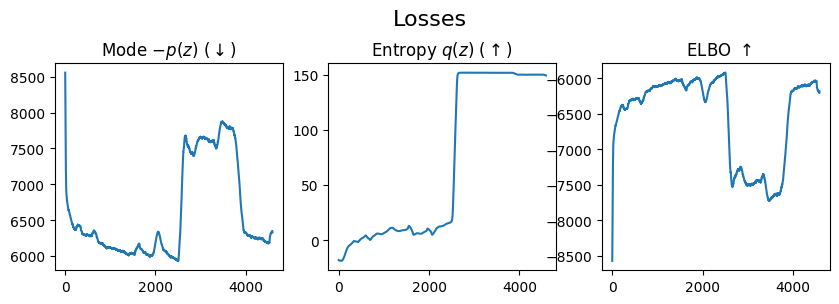

In [8]:
# plot training losses
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (10,3)) 
window_size = 100
mod =  sliding_window_view(losses_mod, window_shape = window_size)
ent = sliding_window_view(losses_ent, window_shape = window_size)

axs[0].plot(np.mean(mod, axis = -1))
axs[0].set_title(r'Mode $- p(z)$ ($\downarrow$)')

axs[1].plot(np.mean(ent, axis = -1))
axs[1].set_title(r'Entropy $q(z)$ ($\uparrow$)' )

axs[2].plot(- np.mean(mod - ent, axis = -1))
axs[2].set_title(r' ELBO $\uparrow$')

fig.suptitle("Losses", fontsize=16)
fig.subplots_adjust(top=0.80)

Original images


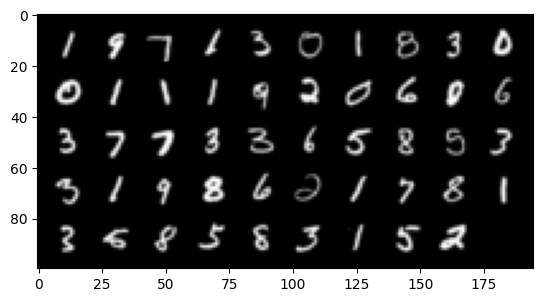

VAE reconstruction:


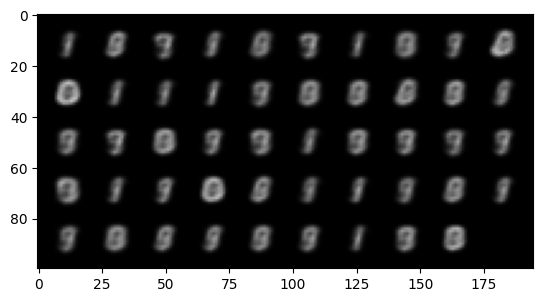

In [9]:
def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def reshape_for_plotting(img_batch):
    return img_batch.view(-1, 1, 14, 14)

def visualise_output(images, model):

    with torch.no_grad():
        _, _, _, _, images_recon = model(images)
        images_recon = torch.sigmoid(images_recon.view(-1, 1, 14, 14))
        np_imagegrid = utils.make_grid(images_recon[1:50], 10, 5).numpy()
        plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        plt.show()
    return images_recon

images, labels = next(iter(test_loader))

# First visualise the original images
print('Original images')
show_image(utils.make_grid(reshape_for_plotting(images[1:50]), 10, 5))
plt.show()

# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
images_recon = visualise_output(images, model)